### Use Case:
**This notebook demonstrates the methods that can be used to discretise images into their primary colors and then seperate and input image into colorwise layers:**

### Approaches:

# Comparison of Color Quantization Methods

| Method                  | Pros                                   | Cons                                     |
|-------------------------|----------------------------------------|------------------------------------------|
| K-means                 | Simple, effective, widely used        | May not handle color distribution well   |
| Median Cut              | Fast, great for dominant colors       | Not as precise for subtle variations     |
| Octree                  | High precision                        | Complex, slower                          |
| PCA                     | Good for subtle variations            | Computationally expensive                |
| Agglomerative Clustering| Captures local relationships          | Slow for large datasets                  |
| SOM                     | Effective for complex distributions   | Hard to implement                        |
| Floyd-Steinberg Dithering| Smooth color transitions             | May not suit sharp edges                 |
| Histogram-Based Quantization | Great for dominant color regions  | Poor results for evenly distributed colors |
| Deep Learning Approaches| Learns complex patterns and styles    | Requires training and computational resources |


In [78]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


In [79]:
output_folder = r"/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output"

### K-means

In [80]:


# def kmeans_discretize_og(image_path, n_colors):
#     """
#     Discretize an image into `n_colors` using K-means clustering.
    
#     Parameters:
#         image_path (str): Path to the input image.
#         n_colors (int): Number of colors to quantize the image into.
    
#     Returns:
#         np.ndarray: Discretized image in RGB format.
#     """
#     # Load the image
#     img = cv2.imread(image_path)
    
#     # Convert the image from BGR (OpenCV default) to RGB
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     # Reshape the image into a 2D array of pixels (each pixel is an RGB value)
#     img_data = img_rgb.reshape((-1, 3))
    
#     # Apply KMeans clustering
#     kmeans = KMeans(n_clusters=n_colors, random_state=0)
#     kmeans.fit(img_data)
    
#     # Replace each pixel with the nearest cluster center
#     new_img_data = kmeans.cluster_centers_[kmeans.labels_]
    
#     # Reshape the result back to the original image shape
#     discretized_img = new_img_data.reshape(img_rgb.shape).astype(np.uint8)
    
#     return discretized_img




#### modified _ kmeans _v2 with silhouttes analysis

### K means with silhouttes analysis: to detect optimal number of clusters for images:

In [104]:


def calculate_clustering_metrics(img_data, max_k=10):
    """
    Calculate clustering metrics for Elbow, Silhouette, and BIC methods.
    
    Parameters:
        img_data (np.ndarray): Image data (reshaped).
        max_k (int): Maximum number of clusters to test.
    
    Returns:
        dict: A dictionary containing inertia, silhouette scores, and BIC scores for each k.
    """
    inertia = []
    silhouette_scores = []
    bic_scores = []

    for k in range(2, max_k + 1):  # Start from 2 clusters since silhouette needs at least 2
        print(f"Calculating metrics for k = {k}...")
        
        # KMeans for inertia and silhouette
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(img_data)
        
        # Append inertia (Elbow Method)
        inertia.append(kmeans.inertia_)
        
        # Append silhouette score (subsample for speed if dataset is large)
        sample_data = img_data[np.random.choice(img_data.shape[0], size=min(1000, img_data.shape[0]), replace=False)]
        silhouette_scores.append(silhouette_score(sample_data, kmeans.labels_[:sample_data.shape[0]]))
        
        # Gaussian Mixture for BIC
        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(img_data)
        bic_scores.append(gmm.bic(img_data))
    
    return {
        "inertia": inertia,
        "silhouette_scores": silhouette_scores,
        "bic_scores": bic_scores
    }

def determine_optimal_clusters(metrics):
    """
    Provide recommendations for optimal clusters based on the metrics.
    
    Parameters:
        metrics (dict): A dictionary containing clustering metrics.
    
    Returns:
        int: Optimal number of clusters based on user input.
    """
    silhouette_scores = metrics["silhouette_scores"]
    bic_scores = metrics["bic_scores"]

    print("\nRecommendations:")
    print(f" - Based on Silhouette, optimal k = {np.argmax(silhouette_scores) + 2}")
    print(f" - Based on BIC, optimal k = {np.argmin(bic_scores) + 2}")

    # Validate user input
    while True:
        try:
            optimal_k = int(input("Enter the optimal number of clusters based on the analysis: "))
            if 2 <= optimal_k <= len(silhouette_scores) + 1:
                break
            else:
                print(f"Please enter a number between 2 and {len(silhouette_scores) + 1}.")
        except ValueError:
            print("Invalid input. Please enter an integer.")
    
    return optimal_k


def display_clustering_metrics(metrics, max_k=10):
    """
    Display the clustering metrics using matplotlib plots.
    
    Parameters:
        metrics (dict): A dictionary containing clustering metrics.
        max_k (int): Maximum number of clusters to test.
    """
    inertia = metrics["inertia"]
    silhouette_scores = metrics["silhouette_scores"]
    bic_scores = metrics["bic_scores"]

   

    # Plot Silhouette Analysis
    plt.subplot(1, 3, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', label="Silhouette Score", color="green")
    plt.title("Silhouette Analysis")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.legend()

    # Plot BIC Scores
    plt.subplot(1, 3, 3)
    plt.plot(range(2, max_k + 1), bic_scores, marker='o', label="BIC", color="red")
    plt.title("BIC Scores")
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC (Lower is Better)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [82]:
# import cv2
# import numpy as np
# from sklearn.cluster import KMeans

# def kmeans_discretize(image_path, n_colors=None):
#     """
#     Discretize an image into `n_colors` using K-means clustering.
    
#     Parameters:
#         image_path (str): Path to the input image.
#         n_colors (int): Number of colors to quantize the image into.
    
#     Returns:
#         np.ndarray: Discretized image in RGB format.
#     """
#     # Load the image
#     img = cv2.imread(image_path)
#     if img is None:
#         raise FileNotFoundError(f"Image not found or unable to read at path: {image_path}")

#     # Convert the image from BGR to RGB
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_rgb_high_quality = img_rgb

#     # Resize for faster processing
#     img_rgb_low_quality = cv2.resize(img_rgb, (500, 500), interpolation=cv2.INTER_AREA)  # Adjust size if needed
#     img_data_low_quality = img_rgb_low_quality.reshape((-1, 3))
#     img_data_high_quality = img_rgb_high_quality.reshape((-1, 3))

#     print("image reading done\n")
    
#     if n_colors is not None:
#         # Apply KMeans clustering
#         kmeans = KMeans(n_clusters=n_colors, random_state=0, n_init="auto")
#         kmeans.fit(img_data_high_quality)
#     else:
       
#         # Calculate metrics and determine optimal clusters
#         metrics = calculate_clustering_metrics(img_data_low_quality, max_k=10)  # Reduce max_k for speed
#         display_clustering_metrics(metrics, max_k=10)

#         print("metrics done \n")
#         optimal_k = determine_optimal_clusters(metrics)
#         print("######## ",optimal_k," #######")
        
#         # Apply KMeans with optimal clusters
#         kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init="auto")
#         kmeans.fit(img_data_high_quality)

#     # Replace each pixel with the nearest cluster center
#     new_img_data = kmeans.cluster_centers_[kmeans.labels_]

#     # Round the cluster centers to the nearest integer to ensure distinct RGB values
#     new_img_data = np.round(new_img_data).astype(np.uint8)
    
#     # Reshape the result back to the original image shape
#     discretized_img = new_img_data.reshape(img_rgb.shape)
    
#     return discretized_img



### Retain  key color approach:

In [100]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def hex_to_rgb(hex_color):
    """
    Convert a hex color string to an RGB tuple.
    
    Parameters:
        hex_color (str): Hex color code (e.g., "#FFFFFF").
    
    Returns:
        tuple: RGB color as a tuple (R, G, B).
    """
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def kmeans_discretize(image_path, n_colors=None, key_colors=None):
    """
    Discretize an image into `n_colors` using K-means clustering, ensuring that key colors are preserved.

    Parameters:
        image_path (str): Path to the input image.
        n_colors (int): Total number of colors to quantize the image into.
        key_colors (list): List of hex color codes to be preserved in the clustering.

    Returns:
        np.ndarray: Discretized image in RGB format.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found or unable to read at path: {image_path}")

    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_data = img_rgb.reshape((-1, 3))

    # Handle case where n_colors is None
    if n_colors is None:
        # Calculate metrics and determine optimal clusters
        metrics = calculate_clustering_metrics(img_data, max_k=10)
        display_clustering_metrics(metrics, max_k=10)
        print("metrics done \n")
        n_colors = determine_optimal_clusters(metrics)
        print(f"Optimal number of clusters: {n_colors}")

    # If no key colors are provided, use the standard KMeans method
    if not key_colors:
        kmeans = KMeans(n_clusters=n_colors, random_state=0, n_init="auto")
        kmeans.fit(img_data)
        new_img_data = kmeans.cluster_centers_[kmeans.labels_]

        # Round the cluster centers to the nearest integer to ensure distinct RGB values
        new_img_data = np.round(new_img_data).astype(np.uint8)

        # Reshape the result back to the original image shape
        discretized_img = new_img_data.reshape(img_rgb.shape)

        # Convert the image back to BGR for saving with OpenCV
        discretized_img_bgr = cv2.cvtColor(discretized_img, cv2.COLOR_RGB2BGR)

        # Save the image (optional)
        output_path = "discretized_image.jpg"
        cv2.imwrite(output_path, discretized_img_bgr)

        return discretized_img

    # Convert key colors from hex to RGB
    key_colors_rgb = [hex_to_rgb(color) for color in key_colors]

    if n_colors < len(key_colors_rgb):
        raise ValueError("The number of colors (n_colors) must be greater than or equal to the number of key colors.")

    # Initialize KMeans clustering for remaining colors
    remaining_clusters = n_colors - len(key_colors_rgb)
    additional_centers = np.empty((0, 3))  # Default for no additional clusters

    if remaining_clusters > 0:
        kmeans = KMeans(n_clusters=remaining_clusters, random_state=0, n_init="auto")
        kmeans.fit(img_data)
        additional_centers = kmeans.cluster_centers_

    # Combine key colors with cluster centers
    combined_centers = np.vstack((key_colors_rgb, additional_centers))

    # Assign each pixel to the nearest cluster center
    labels = np.argmin(np.linalg.norm(img_data[:, None] - combined_centers, axis=2), axis=1)
    new_img_data = combined_centers[labels]

    # Round the cluster centers to the nearest integer to ensure distinct RGB values
    new_img_data = np.round(new_img_data).astype(np.uint8)

    # Reshape the result back to the original image shape
    discretized_img = new_img_data.reshape(img_rgb.shape)

    # Convert the image back to BGR for saving with OpenCV
    discretized_img_bgr = cv2.cvtColor(discretized_img, cv2.COLOR_RGB2BGR)

    # Save the image (optional)
    output_path = "discretized_image_with_key_colors.jpg"
    cv2.imwrite(output_path, discretized_img_bgr)

    return discretized_img


### Code to find out most frequent colors with distance in mind:

In [99]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def hex_to_rgb(hex_color):
    """Convert a hex color string to an RGB tuple."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb_color):
    """Convert an RGB tuple to a hex color string."""
    return '#{:02x}{:02x}{:02x}'.format(*rgb_color)
def find_dominant_colors(image_path, n_colors, min_distance=100):
    """
    Find the n most dominant colors in an image, ensuring they are distinct and sufficiently spaced.

    Parameters:
        image_path (str): Path to the input image.
        n_colors (int): Number of distinct dominant colors to find.
        min_distance (float): Minimum Euclidean distance between selected colors.

    Returns:
        list: List of hex codes of the dominant colors.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found or unable to read at path: {image_path}")
    
    # Convert to RGB and reshape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_data = img_rgb.reshape((-1, 3))
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_colors * 3, random_state=0, n_init="auto")  # Use more clusters initially
    kmeans.fit(img_data)
    cluster_centers = kmeans.cluster_centers_
    
    # Select distinct colors based on min_distance
    selected_colors = []
    for center in cluster_centers:
        if len(selected_colors) == 0:
            selected_colors.append(center)
        elif all(cdist([center], [color]) > min_distance for color in selected_colors):
            selected_colors.append(center)
            if len(selected_colors) >= n_colors:
                break
    
    # Convert selected colors to hex
    hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(c[0]), int(c[1]), int(c[2])) for c in selected_colors[:n_colors]]
    
    return hex_colors


# Example Usage
image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/3.png"
n_colors = 5
dominant_colors = find_dominant_colors(image_path, n_colors)
print("Dominant Colors:", dominant_colors)


Dominant Colors: ['#653915', '#bcdbe6', '#ea9a07', '#6a6f7a', '#c69977']


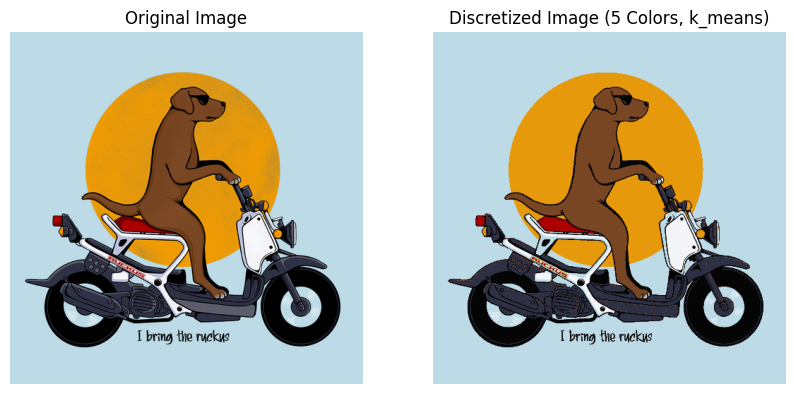

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/3_discretized_5_k_means.png


In [107]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/3.png"
method = "k_means"  # Specify the conversion method
# Perform Median Cut quantization
output_image = kmeans_discretize(input_image_path, 7, ['#ac0000', '#e5990b', '#bcdbe6', '#794623', '#f4f5f9', '#060506', "2e3043"])
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

### Median Cut

In [6]:
def median_cut_discretize(image_path, n_colors):
    """
    Discretize an image into `n_colors` using the Median Cut Algorithm.
    
    Parameters:
        image_path (str): Path to the input image.
        n_colors (int): Number of colors to quantize the image into.
    
    Returns:
        PIL.Image.Image: Discretized image.
    """
    # Open the image using Pillow
    img = Image.open(image_path)
    
    # Convert to RGB if the image is in RGBA mode
    if img.mode == "RGBA":
        img = img.convert("RGB")
    
    # Apply Median Cut quantization
    quantized_img = img.quantize(colors=n_colors, method=0)  # method=0 is Median Cut
    
    return quantized_img

### k-d trees

In [7]:
from sklearn.neighbors import KDTree
import numpy as np
from PIL import Image
from sklearn.cluster import MiniBatchKMeans

# Function to reduce colors using optimized k-d tree quantization
def kd_tree_discretize(image_path, n_colors):
    """
    Reduce the number of colors in the image using k-d tree-based quantization.

    :param image_path: Path to the input image.
    :param n_colors: Number of colors to reduce to.
    :return: Discretized image in RGBA format.
    """
    # Load the image and convert to RGBA
    img = Image.open(image_path).convert("RGBA")
    img_data = np.array(img)

    # Flatten the image data (ignore transparency for quantization)
    rgb_data = img_data[:, :, :3].reshape(-1, 3)

    # Perform k-means clustering to identify a reduced color palette
    
    kmeans = MiniBatchKMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(rgb_data)
    palette = kmeans.cluster_centers_

    # Build a k-d tree for efficient nearest neighbor search
    kd_tree = KDTree(palette)

    # Quantize the image by mapping each pixel to its nearest palette color
    _, nearest_palette_indices = kd_tree.query(rgb_data)
    new_img_data = palette[nearest_palette_indices.flatten()]

    # Reshape the quantized data to the original image dimensions
    discretized_img = new_img_data.reshape(img_data.shape[:2] + (3,))
    discretized_img = np.dstack((discretized_img, img_data[:, :, 3]))

    return Image.fromarray(discretized_img.astype(np.uint8), mode="RGBA")


### hierarchical_color_separation

In [9]:
import numpy as np
from PIL import Image
import os
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.utils import shuffle

# Function to reduce colors using hierarchical clustering
def hierarchical_discretize(image_path, n_colors):
    """
    Reduce the number of colors in the image using hierarchical clustering.

    :param image_path: Path to the input image
    :param n_colors: Number of colors to reduce to
    :return: Discretized image in RGBA format
    """
    # Open the image and convert it to RGBA
    img = Image.open(image_path).convert("RGBA")
    img_data = np.array(img)

    # Flatten the image data (ignore transparency for clustering)
    rgb_data = img_data[:, :, :3].reshape(-1, 3)

    # Sample pixels for hierarchical clustering (optional for large images)
    if rgb_data.shape[0] > 10000:  # Reduce clustering size for large images
        sampled_data = shuffle(rgb_data, n_samples=10000, random_state=0)
    else:
        sampled_data = rgb_data

    # Perform hierarchical clustering on the sampled colors
    linkage_matrix = linkage(sampled_data, method="ward")
    labels_sampled = fcluster(linkage_matrix, t=n_colors, criterion="maxclust")

    # Assign labels to the full image using the centroids
    unique_labels = np.unique(labels_sampled)
    centroids = []
    for label in unique_labels:
        cluster_points = sampled_data[labels_sampled == label]
        centroids.append(cluster_points.mean(axis=0))
    centroids = np.array(centroids).astype(int)

    # Map each pixel to the nearest centroid
    labels_full = np.zeros(rgb_data.shape[0], dtype=int)
    for i, color in enumerate(rgb_data):
        differences = np.linalg.norm(centroids - color, axis=1)
        labels_full[i] = np.argmin(differences)

    # Create the output image using the centroids
    new_img_data = centroids[labels_full].reshape(img_data.shape[:2] + (3,))
    discretized_img = np.dstack((new_img_data, img_data[:, :, 3]))  # Add alpha channel

    return Image.fromarray(discretized_img.astype(np.uint8), mode="RGBA")

## Functions to SAVE the images:

In [106]:

def save_discretized_image(image, input_path, n_colors, method):
    """
    Save the discretized image with a modified file name, ensuring it is saved as PNG.
    
    Parameters:
        image (PIL.Image.Image): The discretized image.
        input_path (str): The input image file path.
        n_colors (int): Number of colors in the discretized image.
        method (str): The method used for discretization (e.g., "median_cut").
        output_folder (str): The folder where the image will be saved.
    """
    # Ensure the image is a PIL Image object
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)  # Convert from NumPy array to PIL Image
    
    # Extract the directory, base name, and extension
    directory, filename = os.path.split(input_path)
    name, ext = os.path.splitext(filename)
    
    # Create the output file name with .png extension
    output_filename = f"{name}_discretized_{n_colors}_{method}.png"
    output_path = os.path.join(output_folder, output_filename)
    
    # Save the image as PNG
    image.save(output_path, "PNG")
    print(f"Discretized image saved to {output_path}")


In [105]:
def display_images_side_by_side(original_image_path, discretized_image, n_colors, method):
    """
    Display the original and discretized images side by side.
    
    Parameters:
        original_image_path (str): Path to the original image.
        discretized_image (PIL.Image.Image): The discretized image.
        n_colors (int): Number of colors in the discretized image.
        method (str): The method used for discretization (e.g., "median_cut").
    """
    # Load the original image
    original_image = Image.open(original_image_path)
    
    # Display images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(discretized_image)
    plt.title(f"Discretized Image ({n_colors} Colors, {method})")
    plt.axis("off")
    
    plt.show()

### ---- RESULTS ----

#### code to run silhoutte analysis with k-means

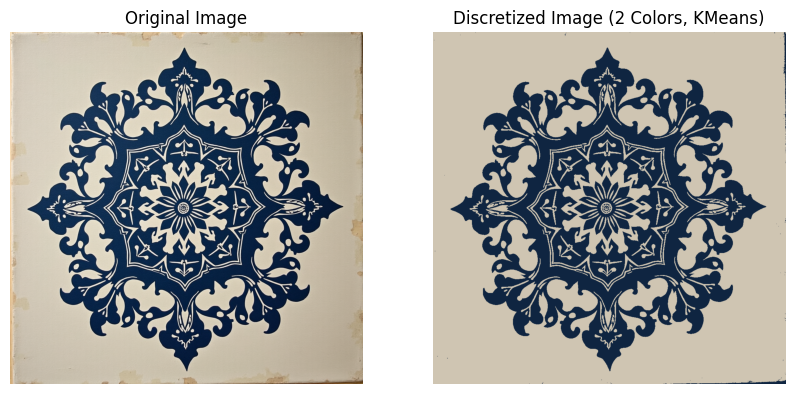

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/test_discretized_2_KMeans.png


In [36]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/test.png"
n_colors = 2  # Set the desired number of colors
method = "KMeans"  # Specify the conversion method
# Perform Median Cut quantization
output_image = kmeans_discretize(input_image_path, n_colors)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

libpng warning: iCCP: known incorrect sRGB profile


image reading done

pca done 

Calculating metrics for k = 2...
Calculating metrics for k = 3...
Calculating metrics for k = 4...
Calculating metrics for k = 5...
Calculating metrics for k = 6...


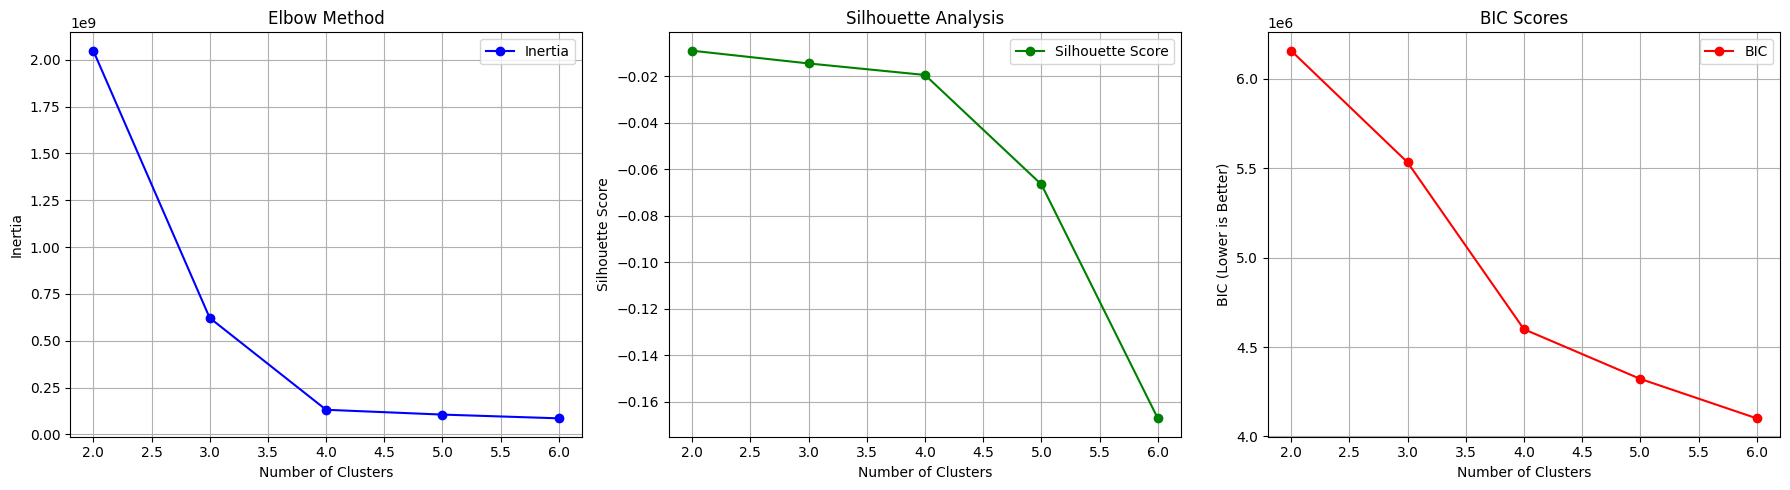

metrics done 


Recommendations:
 - Based on Silhouette, optimal k = 2
 - Based on BIC, optimal k = 6
##########   3   ##########


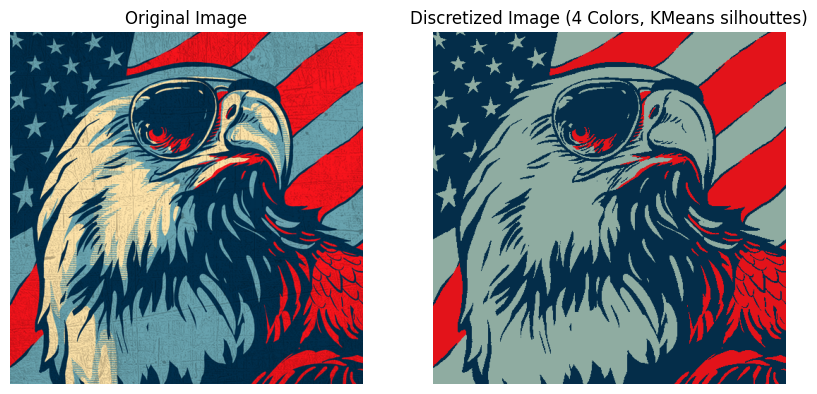

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/5_discretized_4_KMeans silhouttes.png


In [41]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/5.png"
n_colors = 4  # Set the desired number of colors
method = "KMeans silhouttes"  # Specify the conversion method
# Perform Median Cut quantization
output_image = kmeans_discretize(input_image_path)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

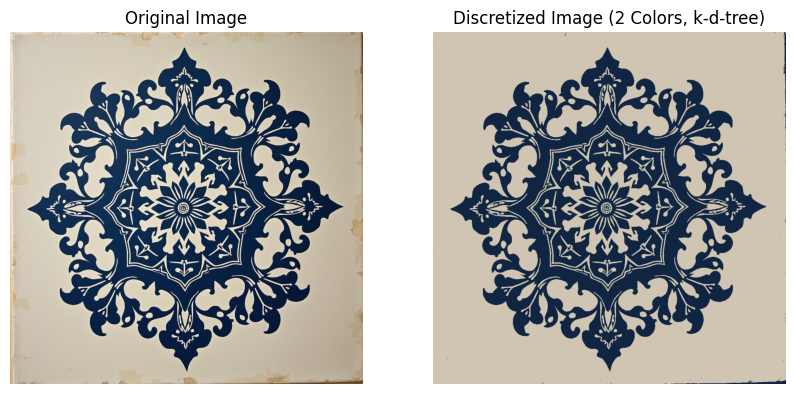

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/test_discretized_2_k-d-tree.png


In [35]:

input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/test.png"
n_colors = 2  # Set the desired number of colors
method = "k-d-tree"  # Specify the conversion method
# Perform Median Cut quantization
output_image = kd_tree_discretize(input_image_path, n_colors)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

Reduced palette colors: [[ 78  88  98]
 [215 206 187]]


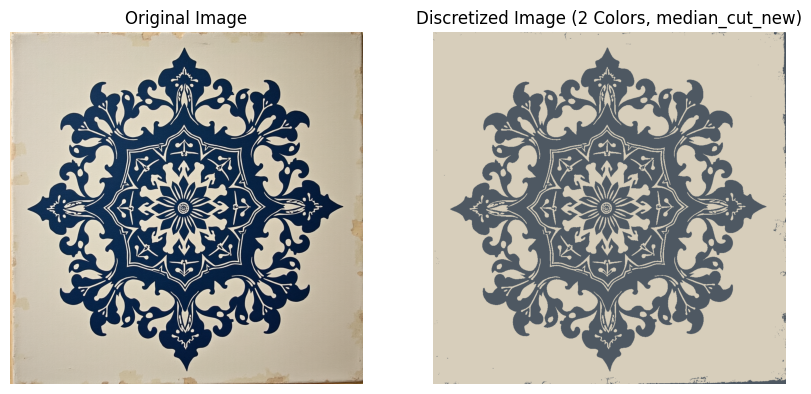

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/test_discretized_2_median_cut_new.png


In [27]:

input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/test.png"
n_colors = 2  # Set the desired number of colors
method = "median_cut_new"  # Specify the conversion method
# Perform Median Cut quantization
output_image = median_cut_discretize_new(input_image_path, n_colors)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

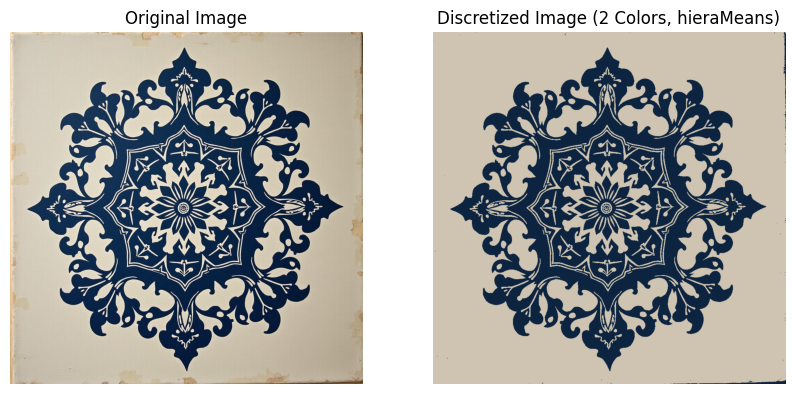

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/test_discretized_2_hieraMeans.png


In [24]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/test.png"
n_colors = 2  # Set the desired number of colors
method = "hieraMeans"  # Specify the conversion method
# Perform Median Cut quantization
output_image = hierarchical_discretize(input_image_path, n_colors)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

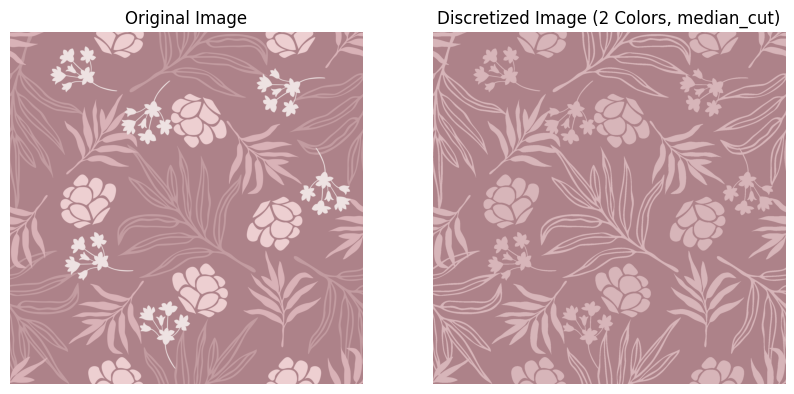

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/lavika_discretized_2_median_cut.png


In [10]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/lavika.png"
n_colors = 2  # Set the desired number of colors
method = "median_cut"  # Specify the conversion method
# Perform Median Cut quantization
output_image = median_cut_discretize(input_image_path, n_colors)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

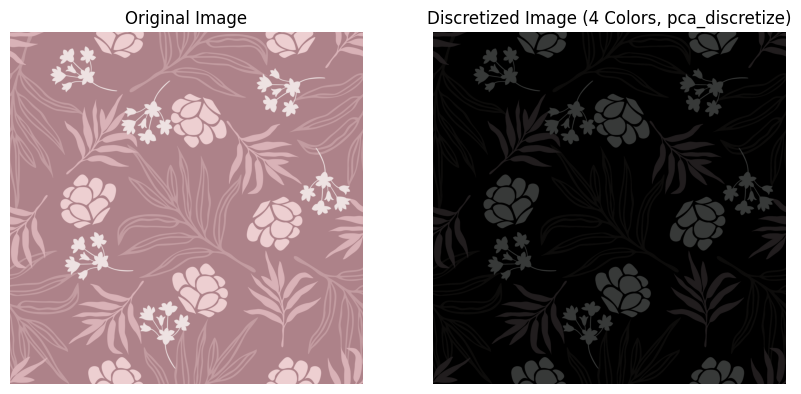

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/lavika_discretized_4_pca_discretize.png


In [ ]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/lavika.png"
n_colors = 4  # Set the desired number of colors
method = "pca_discretize"  # Specify the conversion method
# Perform Median Cut quantization
output_image = pca_discretize(input_image_path, n_colors)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

image reading done

pca done 

Calculating metrics for k = 2...
Calculating metrics for k = 3...
Calculating metrics for k = 4...
Calculating metrics for k = 5...
Calculating metrics for k = 6...
Calculating metrics for k = 7...
Calculating metrics for k = 8...
Calculating metrics for k = 9...
Calculating metrics for k = 10...


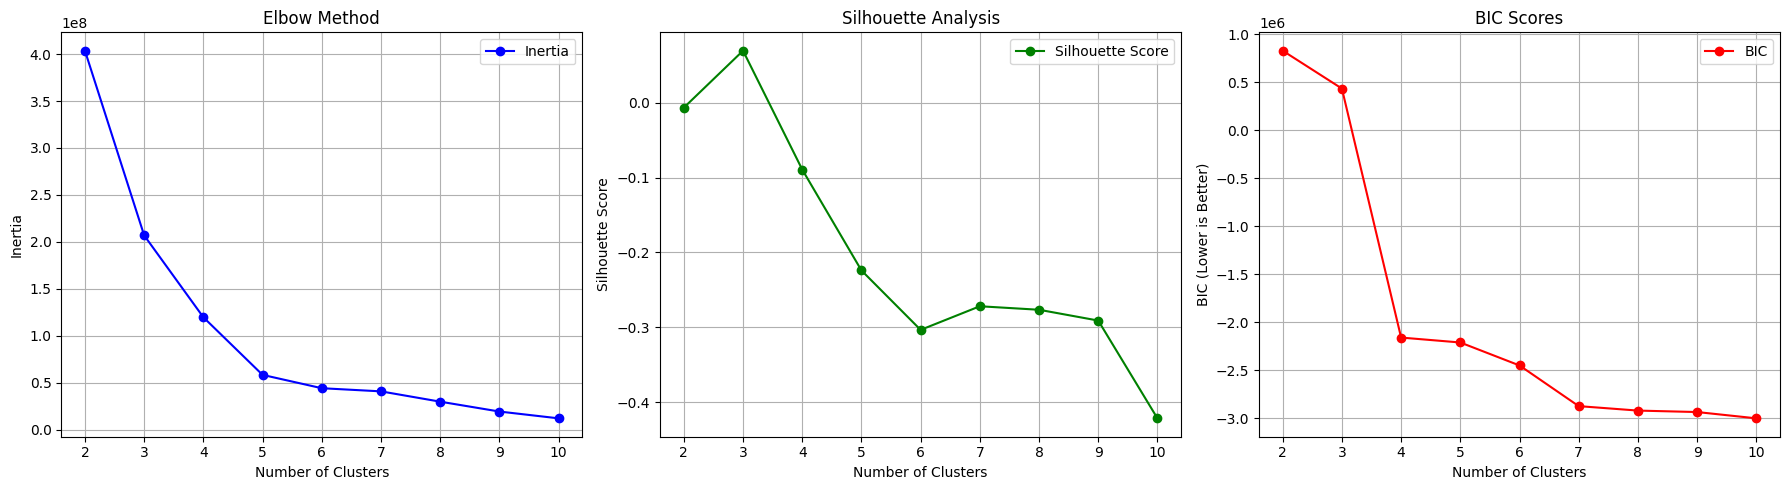

metrics done 


Recommendations:
 - Based on Silhouette, optimal k = 3
 - Based on BIC, optimal k = 10
########  10  #######


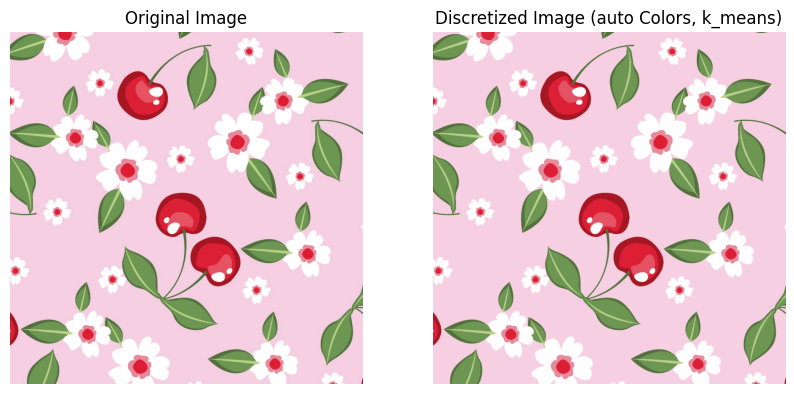

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/lavika3_discretized_auto_k_means.png


In [113]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/lavika3.png"
n_colors = "auto"  # Set the desired number of colors
method = "k_means"  # Specify the conversion method
# Perform Median Cut quantization
output_image = kmeans_discretize(input_image_path)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

image reading done



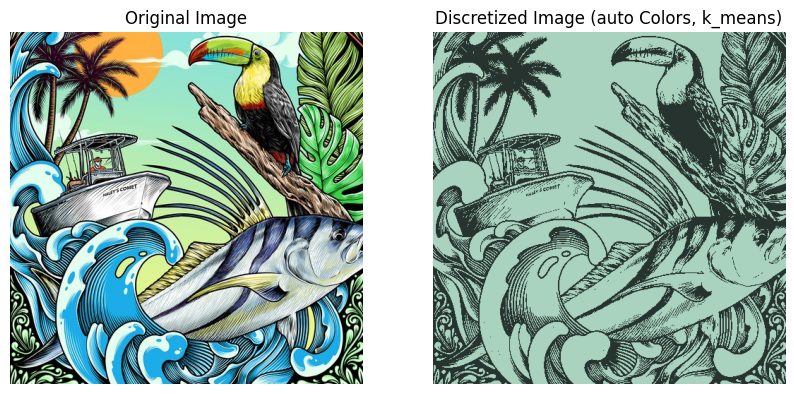

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/2_discretized_auto_k_means.png


In [12]:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/input/2.jpg"
n_colors = "auto"  # Set the desired number of colors
method = "k_means"  # Specify the conversion method
# Perform Median Cut quantization
output_image = kmeans_discretize(input_image_path,2)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

image reading done



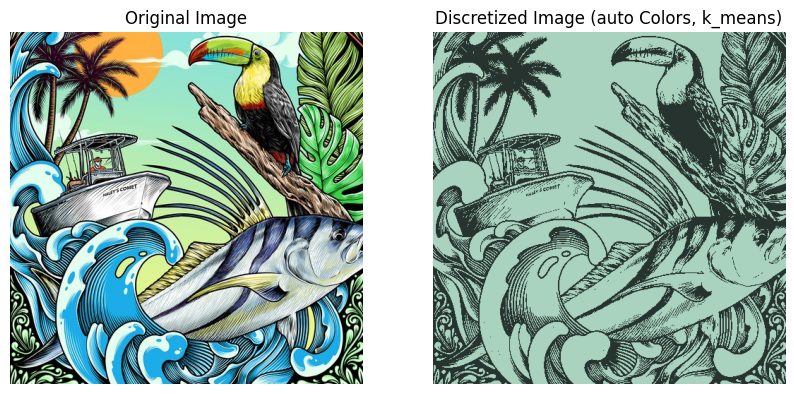

Discretized image saved to /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/2_discretized_auto_k_means.png


In [142]:
output_image = kmeans_discretize(input_image_path,2)
# Display the original and discretized images
display_images_side_by_side(input_image_path, output_image, n_colors, method)
# Save the discretized image with the updated naming convention
save_discretized_image(output_image, input_image_path, n_colors, method)

## Code to make the seperate layers form the images:

In [108]:
# Function to separate individual colors from the image and return separate PNG images
def separate_colors(image_path, n_colors=None, output_dir=None, precision=0):
    """
    Separate the individual colors from the input image and return PNG images for each unique color.
    
    :param image_path: Path to the input image
    :param n_colors: Number of colors to consider (optional, uses all unique colors if None)
    :param output_dir: Directory to save the separated PNG images (optional)
    :param precision: Number of decimal places to round colors (default: 0, which rounds to integers)
    :return: None (Saves the PNG images)
    """
    # Open the image and convert to RGBA (if not already)
    img = Image.open(image_path).convert("RGBA")
    img_data = np.array(img)

    # If output directory is not specified, use the same directory as the input image
    if output_dir is None:
        output_dir = os.path.dirname(image_path)
    
    # Identify the unique colors in the image (considering RGB channels only)
    # Round the colors to remove small differences (if any)
    rgb_data = img_data[:, :, :3].reshape(-1, 3)  # Flatten image data to 2D array
    if precision > 0:
        rgb_data = np.round(rgb_data / (10 ** precision)) * (10 ** precision)  # Round to specified precision
    unique_colors = np.unique(rgb_data, axis=0)
    
    # If n_colors is specified, limit the number of unique colors
    if n_colors is not None:
        unique_colors = unique_colors[:n_colors]
    
    # Debug: Print unique colors detected
    print(f"Detected unique colors: {unique_colors}")
    
    # Create an output folder for the PNG images
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_folder = os.path.join(output_dir, base_name + "_separated_colors")
    os.makedirs(output_folder, exist_ok=True)

    # Process each color and create a new image where only that color is visible
    for idx, color in enumerate(unique_colors):
        # Create a mask for the current color (reshaped to match the original image shape)
        mask = np.all(rgb_data == color, axis=-1)
        
        # Ensure the mask has the same shape as the image data
        mask_reshaped = mask.reshape(img_data[:, :, 0].shape)

        # Create a new image where the current color is visible and others are transparent
        new_img_data = np.zeros_like(img_data)
        new_img_data[mask_reshaped] = img_data[mask_reshaped]  # Keep the color where the mask is true

        # Set the rest to be transparent
        new_img_data[~mask_reshaped, 3] = 0  # Make the other parts transparent

        # Convert back to an image and save
        new_image = Image.fromarray(new_img_data)
        color_name = "_".join(map(str, color))  # Name the image by the color value
        new_image.save(os.path.join(output_folder, f"{base_name}_color_{color_name}.png"))
        print(f"Saved: {base_name}_color_{color_name}.png")

# Example usage:
input_image_path = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/3_discretized_5_k_means.png"
n_colors = None  # Set to None to use all unique colors in the image
output_directory = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_seperated_images"  # Specify the output directory or None to use the same as input

separate_colors(input_image_path, n_colors, output_directory)


Detected unique colors: [[  6   5   6]
 [ 46  48  67]
 [121  70  35]
 [172   0   0]
 [188 219 230]
 [229 153  11]
 [244 245 249]]
Saved: 3_discretized_5_k_means_color_6_5_6.png
Saved: 3_discretized_5_k_means_color_46_48_67.png
Saved: 3_discretized_5_k_means_color_121_70_35.png
Saved: 3_discretized_5_k_means_color_172_0_0.png
Saved: 3_discretized_5_k_means_color_188_219_230.png
Saved: 3_discretized_5_k_means_color_229_153_11.png
Saved: 3_discretized_5_k_means_color_244_245_249.png


In [137]:
import numpy as np
from PIL import Image

# Function to count the unique colors in an image
def count_unique_colors(image_path):
    # Open the image and convert it to RGBA (if not already)
    img = Image.open(image_path).convert("RGBA")
    
    # Convert the image to a numpy array
    img_data = np.array(img)
    
    # Reshape the array to a 2D array of RGB values (ignoring alpha)
    rgb_data = img_data[:, :, :3].reshape(-1, 3)
    
    # Find the unique colors
    unique_colors = np.unique(rgb_data, axis=0)
    
    # Count the unique colors
    unique_color_count = len(unique_colors)
    
    print(f"Number of unique colors: {unique_color_count}")
    return unique_colors

# Example usage:
image_path = r"/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_limit_output/lavika4_discretized_auto_k_means.png"
unique_colors = count_unique_colors(image_path)


Number of unique colors: 7


### collage maker

In [109]:
import os
from PIL import Image, ImageOps
import math

def create_collage(input_folder, output_path, border_size=2, images_per_row=3):
    # Get all PNG files in the folder
    images = []
    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            
            # Add a 2px black border to the image
            img_with_border = ImageOps.expand(img, border=border_size, fill='black')
            images.append(img_with_border)
    
    if not images:
        print("No PNG images found in the folder.")
        return

    # Calculate number of rows needed
    num_images = len(images)
    num_rows = math.ceil(num_images / images_per_row)

    # Calculate dimensions for the collage
    total_width = max(img.width for img in images) * images_per_row
    total_height = max(img.height for img in images) * num_rows

    # Create a blank image with a transparent background to hold the collage
    collage = Image.new('RGBA', (total_width, total_height), (0, 0, 0, 0))

    # Paste images into the collage
    x_offset = 0
    y_offset = 0
    for i, img in enumerate(images):
        collage.paste(img, (x_offset, y_offset), img)  # The third argument ensures transparency

        # Update offsets for next image
        x_offset += img.width
        if (i + 1) % images_per_row == 0:  # Move to next row after 3 images
            x_offset = 0
            y_offset += img.height

    # Save the collage to the output path
    collage.save(output_path)
    print(f"Collage saved at {output_path}")



# Example usage
folder = "/Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_seperated_images/3_discretized_5_k_means_separated_colors"
output = os.path.join(folder, "__final__collage.png")
create_collage(folder, output)


Collage saved at /Users/hamzabaig/Desktop/Project_Impetus/color_seperation/color_seperated_images/3_discretized_5_k_means_separated_colors/__final__collage.png
